In [1]:
import yfinance as yf
import pandas as pd
import os

In [325]:
ticker = 'TNYA'
stock = yf.Ticker(ticker)
stock = stock.history(period="max")
stock.to_csv(ticker +'.csv')

In [326]:
stock.index = pd.to_datetime(stock.index)
stock.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-07-30 00:00:00-04:00,19.500000,21.000000,15.350000,15.350000,2046100,0.0,0.0
2021-08-02 00:00:00-04:00,16.490000,18.330000,15.830000,18.320000,378600,0.0,0.0
2021-08-03 00:00:00-04:00,18.000000,18.750000,17.650000,18.209999,64700,0.0,0.0
2021-08-04 00:00:00-04:00,18.430000,19.440001,16.580000,17.230000,351000,0.0,0.0
2021-08-05 00:00:00-04:00,17.650000,19.400000,17.490000,19.000000,376400,0.0,0.0
2021-08-06 00:00:00-04:00,19.400000,19.730000,16.520000,18.500000,284600,0.0,0.0
2021-08-09 00:00:00-04:00,18.000000,19.990000,17.054001,19.990000,342800,0.0,0.0
2021-08-10 00:00:00-04:00,20.410000,20.709999,18.531000,20.000000,283800,0.0,0.0
2021-08-11 00:00:00-04:00,19.799999,20.760000,19.510000,20.540001,214300,0.0,0.0


<Axes: xlabel='Date'>

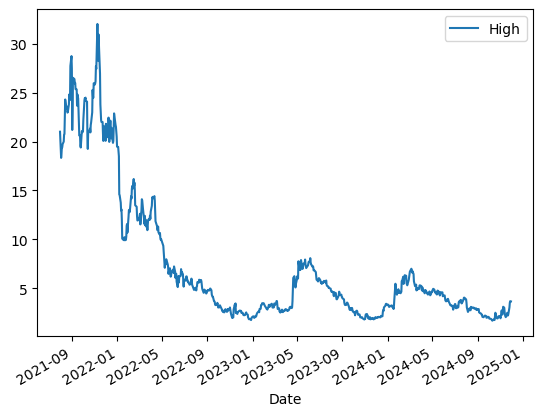

In [327]:
stock.plot.line(y='High', use_index=True)

In [328]:
del stock['Dividends']
del stock['Stock Splits']

In [329]:
stock["Tomorrow"] = stock["Close"].shift(-1)

In [330]:
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

In [331]:
stock = stock.loc["2000-01-01":].copy()

In [332]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, min_samples_split=200, random_state=1)

train = stock.iloc[:-200]
test = stock.iloc[-200:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, n_estimators=200, random_state=1)

In [333]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.2916666666666667

<Axes: xlabel='Date'>

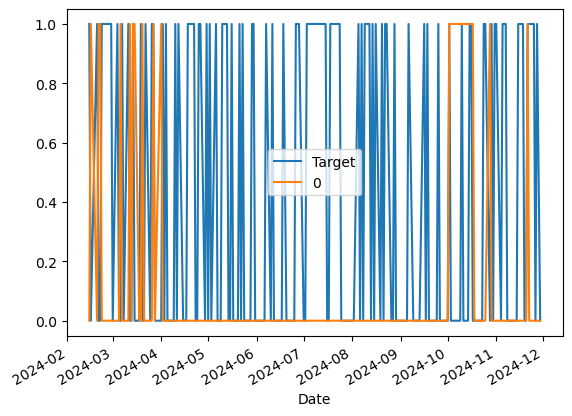

In [334]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [335]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [336]:
def backtest(data, model, predictors, start=500, step=50):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [337]:
predictions = backtest(stock, model, predictors)

In [338]:
predictions["Predictions"].value_counts()

Predictions
0    207
1    133
Name: count, dtype: int64

In [339]:
precision_score(predictions["Target"], predictions["Predictions"])

0.39097744360902253

In [340]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.579412
1    0.420588
Name: count, dtype: float64

In [341]:
scopes = [2,5,60,250]
new_predictors = []

for scope in scopes:
    rolling_averages = stock.rolling(scope).mean()
    
    ratio_column = f"Close_Ratio_{scope}"
    stock[ratio_column] = stock["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{range}"
    stock[trend_column] = stock.shift(1).rolling(scope).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [342]:
stock = stock.dropna(subset=stock.columns[stock.columns != "Tomorrow"])
stock.head(10)

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_<class 'range'>,Close_Ratio_5,Close_Ratio_60,Close_Ratio_250
Date,,,,,,,,,,,,
2022-07-28 00:00:00-04:00,4.85,4.993,4.58,4.86,91400,4.77,0,1.011446,121.0,1.005379,0.807510,0.330421
2022-07-29 00:00:00-04:00,4.83,4.930,4.70,4.77,106900,4.47,0,0.990654,120.0,0.991684,0.802422,0.325501
2022-08-01 00:00:00-04:00,4.71,5.060,4.41,4.47,114400,4.72,1,0.967532,120.0,0.947435,0.761867,0.306178
2022-08-02 00:00:00-04:00,4.41,4.800,4.41,4.72,67800,5.05,1,1.027203,121.0,1.001273,0.812090,0.324414
2022-08-03 00:00:00-04:00,4.82,5.145,4.82,5.05,135600,5.09,1,1.033777,121.0,1.057813,0.874434,0.348432
2022-08-04 00:00:00-04:00,5.04,5.223,4.97,5.09,210300,5.35,1,1.003945,122.0,1.056017,0.885911,0.352496
2022-08-05 00:00:00-04:00,5.02,5.640,4.93,5.35,711200,5.49,1,1.024904,122.0,1.083874,0.937007,0.372010
2022-08-08 00:00:00-04:00,5.49,5.665,5.33,5.49,234400,5.38,0,1.012915,122.0,1.068093,0.964653,0.383292
2022-08-09 00:00:00-04:00,5.48,5.590,5.08,5.38,177600,5.49,1,0.989880,121.0,1.020486,0.950027,0.377209


In [343]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [344]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.65] = 1
    preds[preds <.65] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [345]:
predictions = backtest(stock, model, new_predictors)

In [346]:
predictions["Predictions"].value_counts()

Predictions
0.0    90
Name: count, dtype: int64

In [347]:
precision_score(predictions["Target"], predictions["Predictions"])

C:\Users\mirce\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0

In [348]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.644444
1    0.355556
Name: count, dtype: float64

In [349]:
predictions

,Target,Predictions
Date,,
2024-07-25 00:00:00-04:00,0,0.0
2024-07-26 00:00:00-04:00,0,0.0
2024-07-29 00:00:00-04:00,0,0.0
2024-07-30 00:00:00-04:00,0,0.0
2024-07-31 00:00:00-04:00,0,0.0
...,...,...
2024-11-22 00:00:00-05:00,1,0.0
2024-11-25 00:00:00-05:00,1,0.0
2024-11-26 00:00:00-05:00,0,0.0
